#Load datasets



In [ ]:
import albumentations as A
import cv2
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
path = '/content/drive/MyDrive/DL/coco.pt'            #coco.pt has 10,000 preprossed image and it's captions for image captioning (from coco dataset)
m =torch.load(path)

In [ ]:
NULL_index = m["vocab"]["token_to_idx"]["<NULL>"]

In [ ]:
NULL_index

0

In [ ]:
print(m)    #we can see that m is an dictionary 

{'train_images': tensor([[[[ 50,  72,  96,  ..., 188, 173, 129],
          [ 85,  88,  64,  ..., 116, 110,  93],
          [102, 105, 100,  ...,  99, 101,  87],
          ...,
          [151, 136,  89,  ...,  61,  56,  50],
          [146, 133,  90,  ...,  87,  77,  73],
          [148, 130,  88,  ...,  91,  95,  99]],

         [[ 60,  83, 112,  ..., 197, 181, 142],
          [102, 102,  76,  ..., 139, 130, 116],
          [127, 128, 119,  ..., 121, 123, 108],
          ...,
          [140, 124,  71,  ...,  66,  68,  59],
          [135, 121,  69,  ...,  95,  87,  81],
          [145, 123,  68,  ..., 100, 111, 115]],

         [[ 65,  86, 115,  ..., 191, 174, 124],
          [104, 102,  79,  ..., 123, 106,  91],
          [129, 131, 122,  ..., 103, 104,  87],
          ...,
          [118, 102,  50,  ...,  58,  48,  45],
          [112,  99,  52,  ...,  91,  81,  74],
          [126,  95,  48,  ...,  93,  96,  98]]],


        [[[255, 255, 255,  ...,  34,  29,  21],
          [255, 25

In [ ]:
m['train_captions'].shape

torch.Size([10000, 17])

In [ ]:
m['train_captions'][0]

tensor([  1,  15, 175,  19,   8, 132, 690,   4,  73,  10,  28, 146,   2,   0,
          0,   0,   0])

In [ ]:
m['train_images'].shape

torch.Size([10000, 3, 112, 112])

In [ ]:
max(m['vocab'][ 'token_to_idx'].values())  #we have 864 words in the dict including stop, start, end etc.

863

In [ ]:
m['vocab'][ 'idx_to_token'][5]   #This is the way to excess the word when we have index

'on'

In [ ]:
#Function to generate the sentence from the indexes for the given image

def generate_caption(caption):
  cc = caption.clone().cpu()
  sentence = ''
  for i in cc:
    sentence += m['vocab'][ 'idx_to_token'][i] 
    sentence += ' '

  return sentence




In [ ]:
generate_caption(m['train_captions'][0])

'<START> two giraffes are in their pen a building and some trees <END> <NULL> <NULL> <NULL> <NULL> '

In [ ]:
images = m['train_images']
captions = m['train_captions']

##Visualizing the Final data

In [ ]:
#Shapes of images and captions

print("Shapes of final images: ", images.shape)
print("Shapes of final captions: ", captions.shape)

Shapes of final images:  torch.Size([10000, 3, 112, 112])
Shapes of final captions:  torch.Size([10000, 17])


Image: 


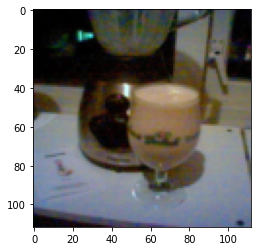

It's captions: 
<START> a table with a blender and a glass on it <END> <NULL> <NULL> <NULL> <NULL> <NULL> 


In [ ]:
#Displaying one image with it's captions:
import matplotlib.pyplot as plt 
import numpy as np

idx = 10
print("Image: ")
plt.imshow((images[idx].permute(1,2,0)).numpy())
plt.show()

print("It's captions: ")
print(generate_caption(captions[idx]))

In [ ]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [ ]:
images = torch.tensor(images.clone(), device= DEVICE)
captions = torch.tensor(captions.clone(), device= DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


#Building the forward pass

First we will use LSTM (long short term memory) for image captioning.

Credits for the photo: Professor [Justin Johnson](https://web.eecs.umich.edu/~justincj/)

#LSTM:
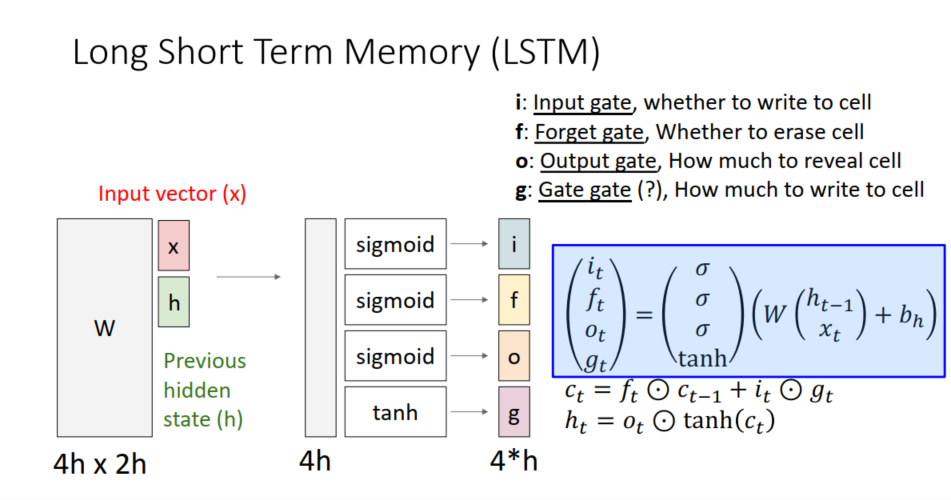

##Feature Extractor
Using VGG-19 as feature extractor

In [ ]:
#Using VGG-19 as feature extractor

from torchvision.models.vgg import vgg19
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for vgg19.
backbone_model = vgg19(pretrained= True).to(DEVICE)
train_nodes, eval_nodes = get_graph_node_names(vgg19())

#Doing requiregrsd =False for pretrained model
for param in backbone_model.parameters():
    param.requires_grad = False

backbone_model.requires_grad_(False)
backbone_model.eval()  

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
print(train_nodes)
print(eval_nodes)
#We can select the nodes we want to extract the features from from following: 

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'fea

In [ ]:
return_nodes = {
    # node_name: user-specified key for output dict
    'classifier.4': 'layer1'
}

In [ ]:
backbone_feature_extractor = create_feature_extractor(backbone_model, return_nodes=return_nodes).to(DEVICE)

In [ ]:
import torchvision
images = images/255.0

#Normalize
norm = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
images = norm(images)   #Don't plot the normalized images directly using matplotlib it will clip he negative values

In [ ]:
def feature_extractor(img):  
  with torch.no_grad():
    out = backbone_feature_extractor(img)
    features = out['layer1']
  return features

In [ ]:
feature_out = feature_extractor(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2]))
print("Output from the Feature extractor network (VGG19) for a single image: ", feature_out.shape)

Output from the Feature extractor network (VGG19) for a single image:  torch.Size([1, 4096])


In [ ]:
import math

#We can use this to initialize our weights and do forward pass (matrix multiplication)
vocab_size=15
embed_size=10

W_embed = nn.Parameter(
            torch.randn(vocab_size, embed_size).div(math.sqrt(vocab_size)) )
print(W_embed.shape)  #Basically it will make a matrix which will be an learnable weight matrix

torch.Size([15, 10])


In [ ]:
#We can also use this to initialize our weights and do forward pass (matrix multiplication)
tryy = nn.Linear(vocab_size, embed_size)
mat = torch.ones(10,15)
tryy(mat).shape

torch.Size([10, 10])

# Making LSTM architecture

In [ ]:
class lstm(nn.Module):

  def __init__(self, time_steps, word_size, embedding_size, feature_size, hidden_size):     #word size is the length of one hot encoded vector which goes as input to embedding layer 
    super(lstm, self).__init__()

    self.word_size = word_size
    self.time_steps = time_steps
    self.hidden_size = hidden_size
    self.embedding = nn.Linear(word_size, embedding_size)    #one hot encoding goes here and produces input for the next hidden layer
    self.wi = nn.Linear(feature_size, hidden_size*4)           #
    self.wx = nn.Linear(embedding_size, hidden_size*4)
    self.wh = nn.Linear(hidden_size, hidden_size*4)

    self.output = nn.Linear(hidden_size, word_size)
    self.sig = nn.Sigmoid()
    
  def forward(self, x, features):
    hidden = torch.rand((x.shape[1], self.hidden_size), device= DEVICE)
    
    output = torch.zeros((self.time_steps, x.shape[1],self.word_size ), device= DEVICE)

    c = torch.ones((x.shape[1], self.hidden_size), device= DEVICE)*0.0

    for i in range(self.time_steps):

      #output = torch.zeros((self.time_steps, x.shape[1],self.word_size ), device= DEVICE)

      #Passing the one hot encoded input x to embedding layer:
      out = self.embedding(x[i])

      #passing the all required outputs to hidden layer and get hidden output h
      hidden1 = (self.wi(features) + self.wx(out) + self.wh(hidden))       

      i_ = hidden1[:, 0:int(hidden1.shape[1]/4)]
      f = hidden1[:, int(hidden1.shape[1]/4):int(2*hidden1.shape[1]/4)]
      o = hidden1[:, int(2*hidden1.shape[1]/4):int(3*hidden1.shape[1]/4)]
      g = hidden1[:, int(3*hidden1.shape[1]/4):int(4*hidden1.shape[1]/4)]

      i_ = self.sig(i_)
      f = self.sig(f)
      o = self.sig(o)
      g = torch.tanh(g)

      c = f*c + i_*g

      hidden = o*torch.tanh(c)

      y = self.output(hidden)

      output[i] = y

    return output


  def step_forward(self,features):

    input = torch.zeros(self.word_size, device= DEVICE)
    input[1] = 1.0

    hidden = torch.ones(self.hidden_size, device= DEVICE)
    c = torch.ones(self.hidden_size, device= DEVICE)*0.0
    

    out_f = []

    for i in range(self.time_steps):

      #Passing the one hot encoded input x to embedding layer:
      out = self.embedding(input)
      
      #passing the all required outputs to hidden layer and get hidden output h
      hidden1 = torch.tanh(self.wi(features) + self.wx(out) + self.wh(hidden))

      i_ = hidden1[0:int(hidden1.shape[0]/4)]
      f = hidden1[int(hidden1.shape[0]/4):int(2*hidden1.shape[0]/4)]
      o = hidden1[int(2*hidden1.shape[0]/4):int(3*hidden1.shape[0]/4)]
      g = hidden1[int(3*hidden1.shape[0]/4):int(4*hidden1.shape[0]/4)]

      i_ = self.sig(i_)
      f = self.sig(f)
      o = self.sig(o)
      g = torch.tanh(g)

      c = f*c + i_*g
      
      mx = torch.tanh(c)
      hidden = o*mx

      y = self.output(hidden)      
      maxindx = torch.argmax(y)
      y[:] = 0
      y[maxindx] = 1
      input = y
      out_f.append(maxindx.cpu().numpy())

    return torch.tensor(np.array(out_f), device= DEVICE)




   

In [ ]:
LSTM = lstm(time_steps=17, word_size=864, embedding_size=400, feature_size=4096, hidden_size=1000).to(device=DEVICE)

In [ ]:
ohc = F1.one_hot(captions, num_classes=864)   #  tHIS WILL do the onw hot encoding part for me
print(ohc.shape)
ohcp = ohc.permute(1,0,2)
print(ohcp.shape)

print(ohcp[:,0,:])   

torch.Size([10000, 17, 864])
torch.Size([17, 10000, 864])
tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0')


#Training

In [148]:
optimizer = torch.optim.Adam(LSTM.parameters(), lr=0.001)        #update the weights of the LSTM
loss_type = torch.nn.CrossEntropyLoss()

step_lr = lr_scheduler.StepLR(optimizer, step_size= 500, gamma = 0.65)  

In [149]:
print(images.shape)
print(captions.shape)
print(ohcp.shape)

torch.Size([10000, 3, 112, 112])
torch.Size([10000, 17])
torch.Size([17, 10000, 864])


In [150]:
ohc = torch.tensor(ohc.detach().cpu().numpy(), device= DEVICE, dtype= torch.float32)

In [151]:
ohc.shape
y_target = torch.zeros_like(captions)
print(y_target.shape)

for i in range(y_target.shape[1]-1):

  y_target[:,i] = captions[:,i+1]

print(y_target.shape)

torch.Size([10000, 17])
torch.Size([10000, 17])


In [152]:
#Model Training
loss_graph = []
num_epochs = 2000
num_train = images.shape[0]
batch_size = 100
LSTM.train()
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  imgf = images[random_no]
  x_batch = ohc[random_no]
  y_batch = y_target[random_no]

  x_batch = x_batch.permute(1,0,2)

  optimizer.zero_grad()
  feat = feature_extractor(imgf)
  
  
  y_pred = LSTM.forward(x_batch, feat)
  y_pred = y_pred.permute(1,0,2)
  
 
  y_pred = y_pred.reshape(-1,864)
  y_batch = y_batch.reshape(-1)


  loss =  loss_type(y_pred, y_batch)                                            #nn.functional.cross_entropy(y_pred, y_batch, ignore_index=NULL_index, reduction='sum' )/batch_size
  loss.backward()
  optimizer.step()
  step_lr.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

Epoch:  0 , loss is:  0.29433268308639526
Epoch:  10 , loss is:  0.5532346367835999
Epoch:  20 , loss is:  0.3374733626842499
Epoch:  30 , loss is:  0.4060952365398407
Epoch:  40 , loss is:  0.39504045248031616
Epoch:  50 , loss is:  0.3220958113670349
Epoch:  60 , loss is:  0.3712667226791382
Epoch:  70 , loss is:  0.3283946216106415
Epoch:  80 , loss is:  0.35356855392456055
Epoch:  90 , loss is:  0.3308120667934418
Epoch:  100 , loss is:  0.336870402097702
Epoch:  110 , loss is:  0.35930201411247253
Epoch:  120 , loss is:  0.3530622124671936
Epoch:  130 , loss is:  0.3328814208507538
Epoch:  140 , loss is:  0.30666670203208923
Epoch:  150 , loss is:  0.2975178062915802
Epoch:  160 , loss is:  0.3177398443222046
Epoch:  170 , loss is:  0.33464106917381287
Epoch:  180 , loss is:  0.34615829586982727
Epoch:  190 , loss is:  0.2947825789451599
Epoch:  200 , loss is:  0.2951470613479614
Epoch:  210 , loss is:  0.3169592618942261
Epoch:  220 , loss is:  0.3226691484451294
Epoch:  230 , lo

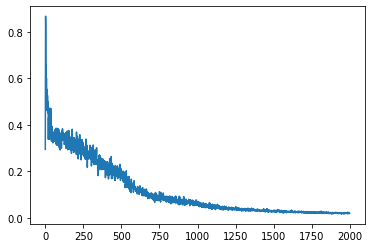

In [153]:
plt.plot(loss_graph)
plt.show()

#Predictions/Inference

In [ ]:
idx = 40
ff1 = feature_extractor(images[idx].reshape(1, images[idx].shape[0], images[idx].shape[1], images[idx].shape[2]))
ff1 = ff1.reshape(-1)
temp = RNN.step_forward(ff1)
print("Generated captions by our model: ")
generate_caption(temp)

Generated captions by our model: 


'a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> <NULL> '

In [ ]:
print("Actual captions: ")
generate_caption(captions[idx])

Actual captions: 


'<START> a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> '